In [1]:
import fitsio
import numpy as np
from matplotlib import pyplot as plt
import sacc
from numpy.lib import recfunctions as rfn
import pyccl as ccl
from scipy.interpolate import interp1d
import healpy as hp

In [52]:
saccs = {}

# DES

The final results will be done with COSMOS15 + the Full DESY1 Sample, metacalibration lensing weights (taken into account when counting neighbors in the photometric sample) and less cuts in COSMOS

In [55]:
Nz_official = fitsio.read('/mnt/extraspace/damonge/Datasets/DES_Y1/shear_catalog/y1_redshift_distributions_v1.fits')

# In DES, nz_true = nz_false(z - dz)
# This is equivalent to (z, nz_true) = (z + dz, nz_false)
# https://arxiv.org/pdf/1708.01530.pdf
prior_official =  {'DESwl__0': (-0.001, 0.016),
                   'DESwl__1': (-0.019, 0.013),
                   'DESwl__2': (0.009, 0.011),
                   'DESwl__3': (-0.018, 0.022)}


# X = np.linspace(-3, 3, 100)
# dz = 0.5
# def gauss(x): 
#     return np.exp(-0.5 * x ** 2) / np.sqrt(2. * np.pi)

# plt.plot(X, gauss(X))
# plt.plot(X, gauss(X - dz))
# plt.plot(X + dz, gauss(X))
# plt.show()
# plt.close()

In [5]:
# sdir = sacc.Sacc.load_fits('output/DES/cls_DES_covG_DIR.fits')
# sdir_fs = sacc.Sacc.load_fits('output/DES/DES_maxd_1_nngh_20_full_sample_nbins100_cls_covG_DIR.fits')
# saccs['fs_riz'] = sacc.Sacc.load_fits('output/DES/DES_maxd_1_nngh_20_riz_full_sample_nbins100_cls_covG_DIR.fits')
# saccs['fs_adj'] = sacc.Sacc.load_fits('output/DES/DES_maxd_1_nngh_20_full_sample_adjoint_colors_nbins100_cls_covG_DIR.fits')
# saccs['fs_metacal_R'] = sacc.Sacc.load_fits('output/DES/DES_R_maxd_1_nngh_20_griz_full_sample_nbins100_cls_covG_DIR.fits')
# saccs['shahab'] = sacc.Sacc.load_fits('output/DES/cls_DES_covG_ShahabNzs.fits')
# saccs['PAU'] = sacc.Sacc.load_fits('output/DES/DES_PAU_maxd_1_nngh_20_nbins100_cls_covG_DIR.fits')
# saccs['PAU_fs_R'] = sacc.Sacc.load_fits('output/DES/DES_PAU_R_maxd_1_nngh_20_griz_full_sample_nbins100_cls_covG_DIR.fits')

# sdir_noflag = sacc.Sacc.load_fits('output/DES/DES_noflaggedcut/cls_DES_covG_DIR.fits')
# sdir_backup = sacc.Sacc.load_fits('output/DES_backup/cls_DES_covG_DIR.fits')

## DES final calibration

In [20]:
# Plotting the photometric sample that we use for DIR
cat = fitsio.read('/mnt/extraspace/gravityls_3/data/DESY1/DESY1wl_short_for_DIR_with_cosmology_patch.fits')

nside = 512
npix = hp.nside2npix(nside)
gal_pix = hp.ang2pix(nside, cat['ra'], cat['dec'], lonlat=True)
gal_map = np.bincount(gal_pix, minlength=npix)
hp.mollview(gal_map)

### R + only cosmology rectangle + COSMOS15 with HSC cuts [IN PAPER]

In [12]:
saccs['DES_final'] = sacc.Sacc.load_fits('output/DES_final/DES_final_COSMOS15_R_maxd_1_nngh_20_griz_cosmo_patch_nbins100_cls_covGNG_DIR.fits')
saccs['DES_final_lc'] = sacc.Sacc.load_fits('output/DES_final/DES_final_COSMOS15_less_cuts_R_maxd_1_nngh_20_griz_cosmo_patch_nbins100_cls_covGNG_DIR.fits')

Tracer name: Our <z> vs Our lc <z> vs Official corrected by prior <z>
DESwl__0: 0.3685270542709141 vs 0.3661205072415226 vs 0.38905547135272084
DESwl__1: 0.5031753845600112 vs 0.5014307189544124 vs 0.507310659194213
DESwl__2: 0.7738361823612185 vs 0.7725314128500511 vs 0.7531195872994767
DESwl__3: 1.0041227076656956 vs 0.998751990100013 vs 0.9497019314399503


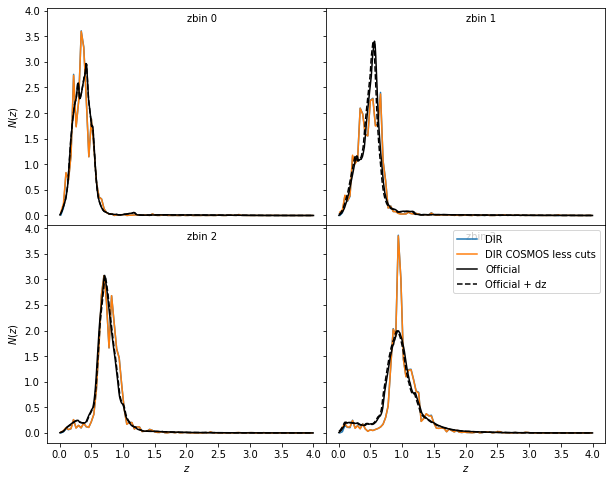

In [23]:
f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
print(f'Tracer name: Our <z> vs Our lc <z> vs Official corrected by prior <z>')
dir_shift = {}
for i in range(4):
    trn = f'DESwl__{i}'
    
    #
    tr = saccs['DES_final'].tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR')
    zmean = np.sum(tr.nz * tr.z)/np.sum(tr.nz)
    
    tr = saccs['DES_final_lc'].tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR COSMOS less cuts')
    zmean2 = np.sum(tr.nz * tr.z)/np.sum(tr.nz)

    # Official Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    c = np.sum(nz) * (z[1] - z[0])
    zmean_official = np.sum(nz * z)/np.sum(nz)
    ax[i].plot(z, nz / c, color='k', label='Official')

    # Official Nz + dz
    dz, sdz = prior_official[trn]
    # Remove z's that will go negative after applying the shift dz
    nz = nz[z>= -dz]
    z = z[z>= -dz]
    z += dz
    ax[i].plot(z, nz / c, '--k', label='Official + dz')
    
    zmean_official_dz = np.sum(nz * z)/np.sum(nz)
    
    ax[i].text(0.5, 0.95, f'zbin {i}', horizontalalignment='left',
     verticalalignment='center', transform=ax[i].transAxes)
    
    dir_shift[trn] = zmean_official_dz - zmean
    print(f'{trn}: {zmean} vs {zmean2} vs {zmean_official_dz}')

for i in range(2):
    ax[i+2].set_xlabel(r'$z$')
    ax[i*2].set_ylabel(r'$N(z)$')
    
plt.legend()
plt.show()
     

Tracer name: Our <z> vs Old with COSMOS + cosmology patch <z> vs Official corrected by prior <z>
DESwl__0: 0.3685270542709141 vs 0.3832815388844123 vs 0.38905547135272084
DESwl__1: 0.5031753845600112 vs 0.5222543150361225 vs 0.507310659194213
DESwl__2: 0.7738361823612185 vs 0.7949879088733867 vs 0.7531195872994767
DESwl__3: 1.0041227076656956 vs 1.0267184576566322 vs 0.9497019314399503


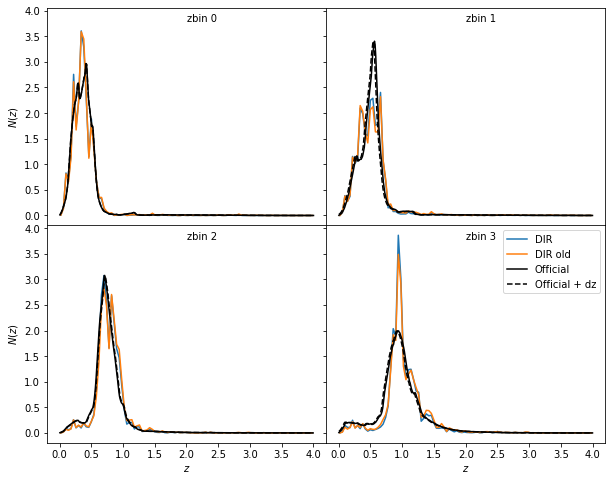

In [9]:
# Comparison between the final run with only the cosmology patch + R
# with the previous case where you had cosmology patch + COSMOS15 square
saccs['cosmo_patch_R'] = sacc.Sacc.load_fits('output/DES/DES_COSMOS15_R_maxd_1_nngh_20_griz_cosmo_patch_nbins100_cls_covGNG_DIR.fits')

f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
print(f'Tracer name: Our <z> vs Old with COSMOS + cosmology patch <z> vs Official corrected by prior <z>')
dir_shift = {}
for i in range(4):
    trn = f'DESwl__{i}'
    tr = saccs['DES_final'].tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR')
    zmean = np.sum(tr.nz * tr.z)/np.sum(tr.nz)

    #
    tr = saccs['cosmo_patch_R'].tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR old')
    zmean2 = np.sum(tr.nz * tr.z)/np.sum(tr.nz)
    
    # Official Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    c = np.sum(nz) * (z[1] - z[0])
    zmean_official = np.sum(nz * z)/np.sum(nz)
    ax[i].plot(z, nz / c, color='k', label='Official')

    # Official Nz + dz
    dz, sdz = prior_official[trn]
    # Remove z's that will go negative after applying the shift dz
    nz = nz[z>= -dz]
    z = z[z>= -dz]
    z += dz
    ax[i].plot(z, nz / c, '--k', label='Official + dz')
    
    zmean_official_dz = np.sum(nz * z)/np.sum(nz)
    
    ax[i].text(0.5, 0.95, f'zbin {i}', horizontalalignment='left',
     verticalalignment='center', transform=ax[i].transAxes)
    
    dir_shift[trn] = zmean_official_dz - zmean
    print(f'{trn}: {zmean} vs {zmean2} vs {zmean_official_dz}')

for i in range(2):
    ax[i+2].set_xlabel(r'$z$')
    ax[i*2].set_ylabel(r'$N(z)$')
    
plt.legend()
plt.show()
     

### Final magnitude comparison with xCell cats (there's a difference on number of ~10k gals in each zbin coming from imposing fluxes > 0 and because the griz and riz catalog must not be exactly the same )

In [35]:
cat = fitsio.read('/mnt/extraspace/gravityls_3/data/DESY1/DESY1wl_short_for_DIR_with_cosmology_patch.fits')
cat_riz = fitsio.read('/mnt/extraspace/gravityls_3/data/DESY1/DESY1wl_short_for_DIR_with__riz.fits')

In [11]:
cat_xcell = fitsio.read('/mnt/extraspace/damonge/Datasets/DES_Y1/shear_catalog/mcal-y1a1-combined-riz-unblind-v4-matched.fits')
cat_xcell_z = fitsio.read('/mnt/extraspace/damonge/Datasets/DES_Y1/shear_catalog/y1_source_redshift_binning_v1.fits')

In [45]:
cat_xcell_dir = fitsio.read('/mnt/extraspace/gravityls_3/data/DESY1/DESY1wl_short_for_DIR_with_cosmology_patch_xCell_riz.fits')

In [28]:
sel_xcell = cat_xcell['flags_select'] == 0
sel_xcell *= cat_xcell_z['zbin_mcal'] >= 0
sel_xcell *= cat_xcell['dec'] > -90
sel_xcell *= cat_xcell['dec'] < -35

sel_xcell *= cat_xcell['flux_r'] > 0
sel_xcell *= cat_xcell['flux_i'] > 0
sel_xcell *= cat_xcell['flux_z'] > 0

In [46]:
cat.shape, cat_riz.shape, np.sum(sel_xcell), cat_xcell_dir.shape

((27924915,), (27987852,), 27992385, (27992385,))

Selecting galaxies in zbin 0


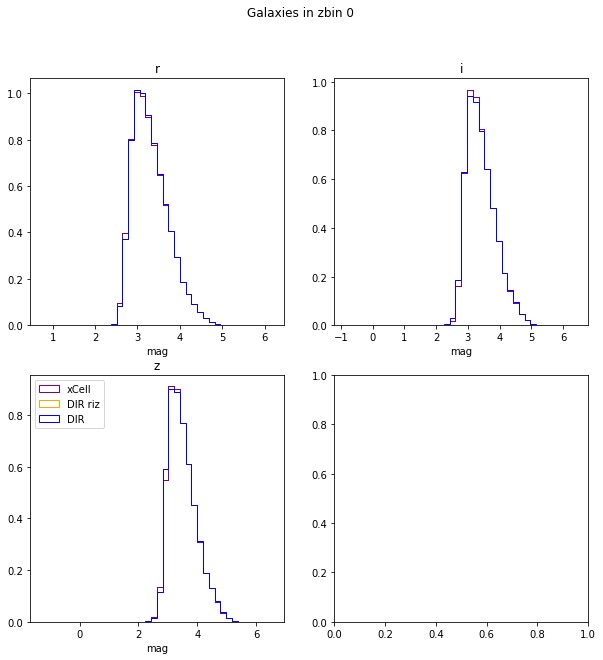

Selecting galaxies in zbin 1


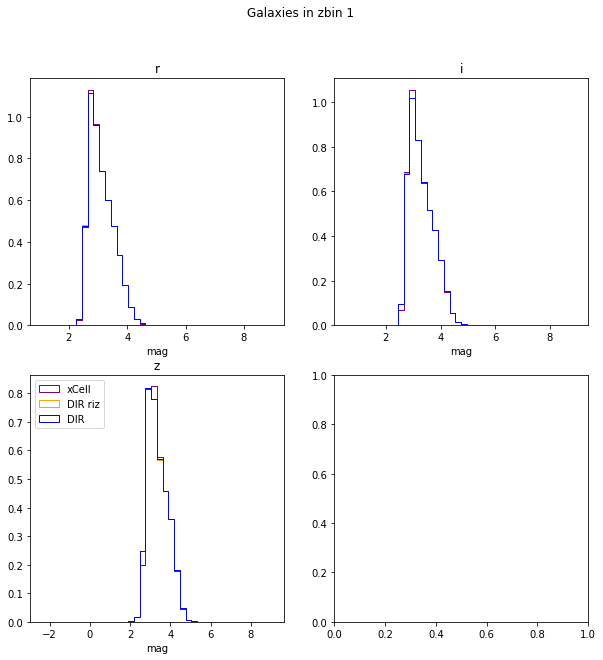

Selecting galaxies in zbin 2


Selecting galaxies in zbin 3


In [48]:
colors = ['r', 'i', 'z']

for zbin in range(4):
    print(f'Selecting galaxies in zbin {zbin}', flush=True)
    # Based on https://github.com/xC-ell/xCell/blob/b00b448d18880afc3b405f939a7aabd934df45be/xcell/mappers/mapper_DESY1wl.py#L92-L96
    sel = cat['zbin_mcal'] == zbin
    sel_riz = cat_riz['zbin_mcal'] == zbin
    sel_x = sel_xcell * (cat_xcell_z['zbin_mcal'] == zbin)
    sel_x_dir = cat_xcell_dir['zbin_mcal'] == zbin

    f, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax = ax.reshape(-1)
    for i, c in enumerate(colors):
        ax[i].hist([cat[sel][f'mag_{c}'],
                    cat_riz[sel_riz][f'mag_{c}'],
                    cat_xcell_dir[sel_x_dir][f'mag_{c}'],
                    np.log10(cat_xcell[sel_x][f'flux_{c}'])],
                   histtype='step',
                   label=['DIR', 'DIR riz', 'xCell'],
                   color=['blue', 'orange', 'purple', 'black'],
                   bins=40, density=True)
        ax[i].set_title(c)
        ax[i].set_xlabel('mag')
    ax[i].legend(loc='upper left')
    f.suptitle(f'Galaxies in zbin {zbin}')
    plt.show()
    plt.close()

Selecting galaxies in zbin 0


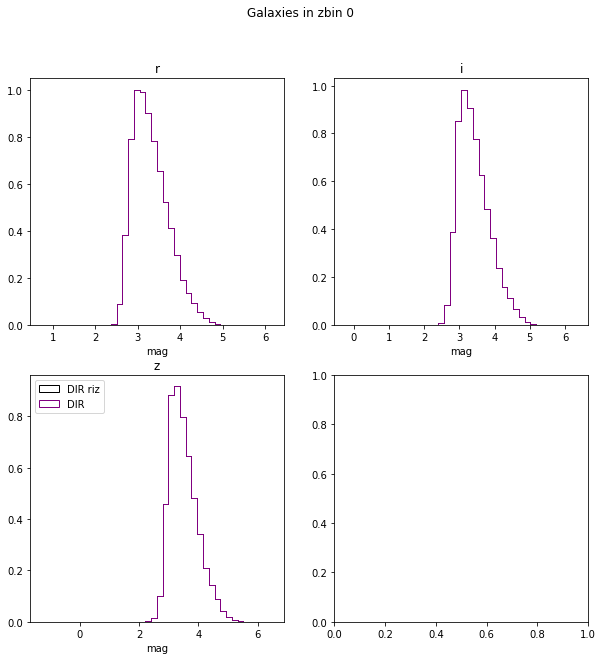

Selecting galaxies in zbin 1


Selecting galaxies in zbin 2


Selecting galaxies in zbin 3


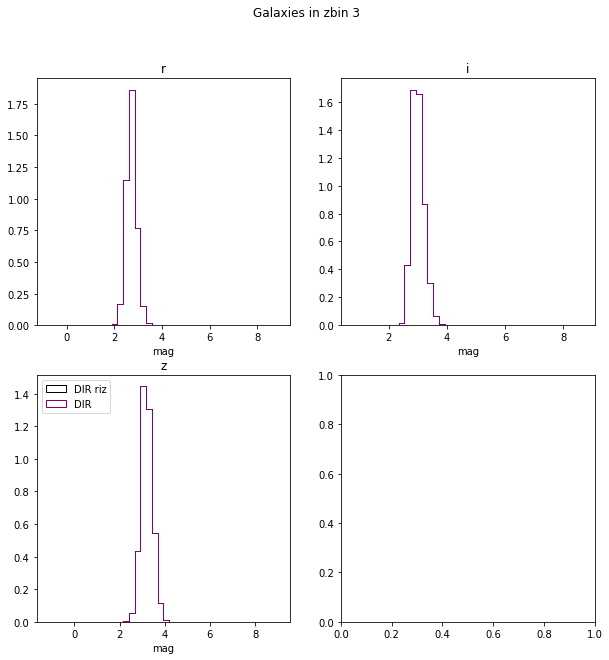

In [50]:
colors = ['r', 'i', 'z']

for zbin in range(4):
    print(f'Selecting galaxies in zbin {zbin}', flush=True)
    # Based on https://github.com/xC-ell/xCell/blob/b00b448d18880afc3b405f939a7aabd934df45be/xcell/mappers/mapper_DESY1wl.py#L92-L96
    sel = cat['zbin_mcal'] == zbin
    sel_riz = cat_riz['zbin_mcal'] == zbin
    sel_x = sel_xcell * (cat_xcell_z['zbin_mcal'] == zbin)
    sel_x_dir = cat_xcell_dir['zbin_mcal'] == zbin

    f, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax = ax.reshape(-1)
    for i, c in enumerate(colors):
        ax[i].hist([cat_xcell_dir[sel_x_dir][f'mag_{c}'],
                    np.log10(cat_xcell[sel_x][f'flux_{c}'])],
                   histtype='step',
                   label=['DIR', 'DIR riz', 'xCell'],
                   color=['purple', 'black'],
                   bins=40, density=True)
        ax[i].set_title(c)
        ax[i].set_xlabel('mag')
    ax[i].legend(loc='upper left')
    f.suptitle(f'Galaxies in zbin {zbin}')
    plt.show()
    plt.close()

### Final (R + cosmology patch + C15 with HSC cuts) but with riz catalaog

In [53]:
saccs['DES_final'] = sacc.Sacc.load_fits('output/DES_final/DES_final_COSMOS15_R_maxd_1_nngh_20_griz_cosmo_patch_nbins100_cls_covGNG_DIR.fits')
saccs['DES_final_xcell'] = sacc.Sacc.load_fits('output/DES_final_xCell/DES_final_xCell_COSMOS15_R_maxd_1_nngh_20_riz_cosmo_patch_xCell_nbins100_cls_covGNG_DIR.fits')

Tracer name: Our <z> vs Our xCell cat <z> vs Official corrected by prior <z>
DESwl__0: 0.3685270542709141 vs 0.3711278172742283 vs 0.38905547135272084
DESwl__1: 0.5031753845600112 vs 0.49823804294070423 vs 0.507310659194213
DESwl__2: 0.7738361823612185 vs 0.7716607306737564 vs 0.7531195872994767
DESwl__3: 1.0041227076656956 vs 0.9933078538004287 vs 0.9497019314399503


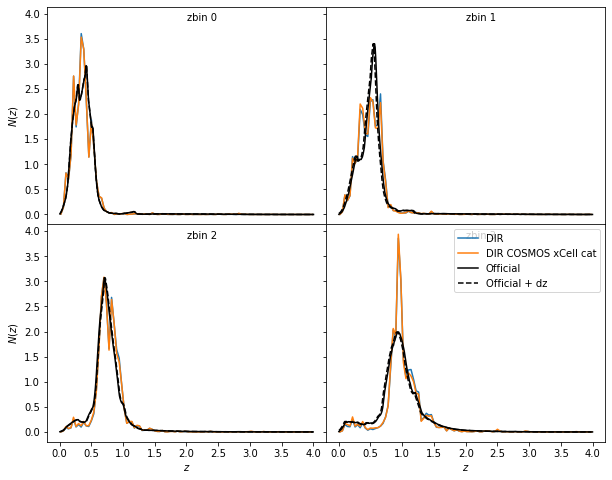

In [57]:
f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
print(f'Tracer name: Our <z> vs Our xCell cat <z> vs Official corrected by prior <z>')
dir_shift = {}
for i in range(4):
    trn = f'DESwl__{i}'
    
    #
    tr = saccs['DES_final'].tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR')
    zmean = np.sum(tr.nz * tr.z)/np.sum(tr.nz)
    
    tr = saccs['DES_final_xcell'].tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR COSMOS xCell cat')
    zmean2 = np.sum(tr.nz * tr.z)/np.sum(tr.nz)

    # Official Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    c = np.sum(nz) * (z[1] - z[0])
    zmean_official = np.sum(nz * z)/np.sum(nz)
    ax[i].plot(z, nz / c, color='k', label='Official')

    # Official Nz + dz
    dz, sdz = prior_official[trn]
    # Remove z's that will go negative after applying the shift dz
    nz = nz[z>= -dz]
    z = z[z>= -dz]
    z += dz
    ax[i].plot(z, nz / c, '--k', label='Official + dz')
    
    zmean_official_dz = np.sum(nz * z)/np.sum(nz)
    
    ax[i].text(0.5, 0.95, f'zbin {i}', horizontalalignment='left',
     verticalalignment='center', transform=ax[i].transAxes)
    
    dir_shift[trn] = zmean_official_dz - zmean
    print(f'{trn}: {zmean} vs {zmean2} vs {zmean_official_dz}')

for i in range(2):
    ax[i+2].set_xlabel(r'$z$')
    ax[i*2].set_ylabel(r'$N(z)$')
    
plt.legend()
plt.show()
     

## Tests

### DES COSMOS patch

Tracer name: Our <z> vs Official <z> vs Official corrected by prior <z>
DESwl__0: 0.4044145809119732 vs 0.39005547135272084 vs 0.38905547135272084 || dz = -0.015359109559252349
DESwl__1: 0.5538383777636466 vs 0.5262341626576512 vs 0.507310659194213 || dz = -0.04652771856943361
DESwl__2: 0.8089056801708394 vs 0.7441195872994767 vs 0.7531195872994767 || dz = -0.055786092871362714
DESwl__3: 1.038554883058279 vs 0.9674512511446484 vs 0.9497019314399503 || dz = -0.08885295161832862


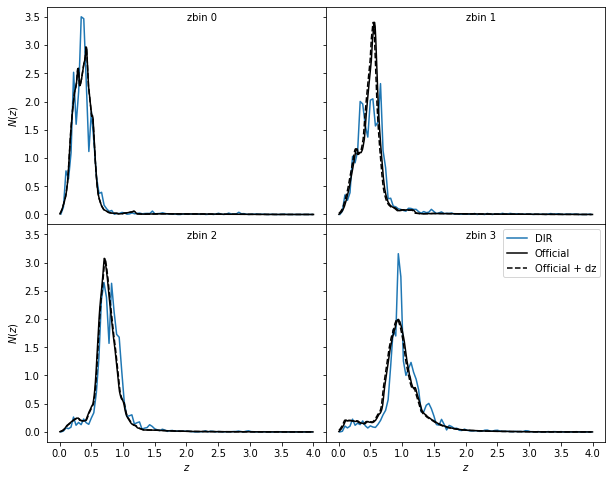

In [5]:
f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
print(f'Tracer name: Our <z> vs Official <z> vs Official corrected by prior <z>')
dir_shift = {}
for i in range(4):
    trn = f'DESwl__{i}'
    tr = sdir.tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR')
    zmean = np.sum(tr.nz * tr.z)/np.sum(tr.nz)

    # Official Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    c = np.sum(nz) * (z[1] - z[0])
    zmean_official = np.sum(nz * z)/np.sum(nz)
    ax[i].plot(z, nz / c, color='k', label='Official')

    # Official Nz + dz
    dz, sdz = prior_official[trn]
    # Remove z's that will go negative after applying the shift dz
    nz = nz[z>= -dz]
    z = z[z>= -dz]
    z += dz
    ax[i].plot(z, nz / c, '--k', label='Official + dz')
    
    zmean_official_dz = np.sum(nz * z)/np.sum(nz)
    
    ax[i].text(0.5, 0.95, f'zbin {i}', horizontalalignment='left',
     verticalalignment='center', transform=ax[i].transAxes)
    
    dir_shift[trn] = zmean_official_dz - zmean
    print(f'{trn}: {zmean} vs {zmean_official} vs {zmean_official_dz} || dz = {dir_shift[trn]}')

for i in range(2):
    ax[i+2].set_xlabel(r'$z$')
    ax[i*2].set_ylabel(r'$N(z)$')
    
plt.legend()
plt.show()
     

Tracer name: Our <z> vs Official <z> vs Official corrected by prior <z>
DESwl__0: 0.38905547521950046 vs 0.39005547135272084 vs 0.38905547135272084 || dz = -0.015359109559252349
DESwl__1: 0.5073106538531027 vs 0.5262341626576512 vs 0.507310659194213 || dz = -0.04652771856943361
DESwl__2: 0.7531195995913473 vs 0.7441195872994767 vs 0.7531195872994767 || dz = -0.055786092871362714
DESwl__3: 0.949701921414054 vs 0.9674512511446484 vs 0.9497019314399503 || dz = -0.08885295161832862


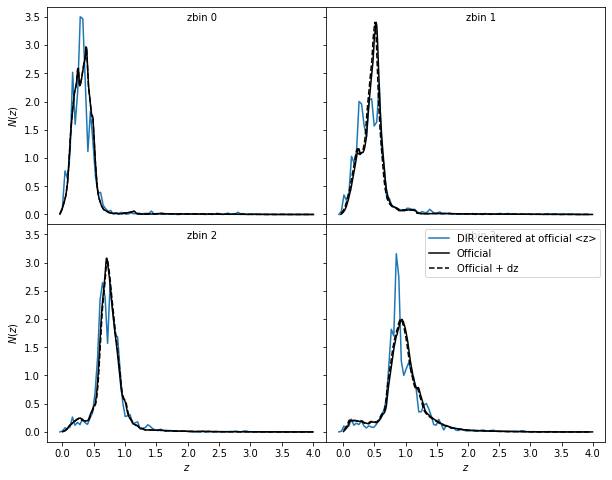

In [11]:
f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
print(f'Tracer name: Our <z> vs Official <z> vs Official corrected by prior <z>')
for i in range(4):
    trn = f'DESwl__{i}'
    tr = sdir.tracers[trn]
    # Remove z's that will go negative after applying the shift dz
    z, nz = tr.z, tr.nz
    nz = nz[z>= -dz]
    z = z[z>= -dz]
    z += dir_shift[trn]
    c = np.sum(nz) * (z[1] - z[0])
    ax[i].plot(z, nz / c, label='DIR centered at official <z>')
    zmean = np.sum(nz * z)/np.sum(nz)

    # Official Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    c = np.sum(nz) * (z[1] - z[0])
    zmean_official = np.sum(nz * z)/np.sum(nz)
    ax[i].plot(z, nz / c, color='k', label='Official')

    # Official Nz + dz
    dz, sdz = prior_official[trn]
    # Remove z's that will go negative after applying the shift dz
    nz = nz[z>= -dz]
    z = z[z>= -dz]
    z += dz
    c = np.sum(nz) * (z[1] - z[0])
    ax[i].plot(z, nz / c, '--k', label='Official + dz')
    
    zmean_official_dz = np.sum(nz * z)/np.sum(nz)
    
    ax[i].text(0.5, 0.95, f'zbin {i}', horizontalalignment='left',
     verticalalignment='center', transform=ax[i].transAxes)
    
    print(f'{trn}: {zmean} vs {zmean_official} vs {zmean_official_dz} || dz = {dir_shift[trn]}')

for i in range(2):
    ax[i+2].set_xlabel(r'$z$')
    ax[i*2].set_ylabel(r'$N(z)$')
    
plt.legend()
plt.show()
     

### DIR with full sample

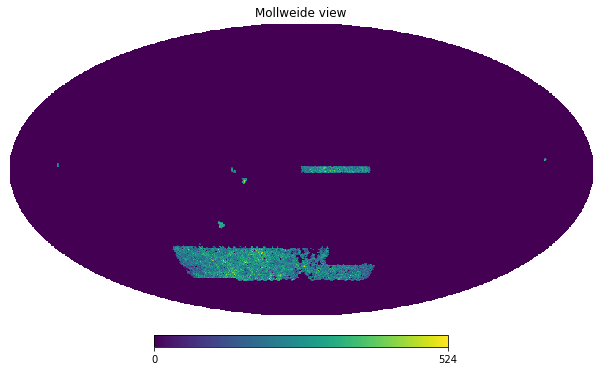

In [21]:
# Plotting the photometric sample that we use for DIR
cat = fitsio.read('/mnt/extraspace/gravityls_3/data/DESY1/DESY1wl_short_for_DIR_with_full_sample.fits')

nside = 512
npix = hp.nside2npix(nside)
gal_pix = hp.ang2pix(nside, cat['ra'], cat['dec'], lonlat=True)
gal_map = np.bincount(gal_pix, minlength=npix)
hp.mollview(gal_map)

Tracer name: Our <z> vs Our FS <z> vs Official <z> vs Official corrected by prior <z>
DESwl__0: 0.4044145809119732 vs 0.38104360353911476 vs 0.39005547135272084 vs 0.38905547135272084
DESwl__1: 0.5538383777636466 vs 0.5225926633064208 vs 0.5262341626576512 vs 0.507310659194213
DESwl__2: 0.8089056801708394 vs 0.7840478213373819 vs 0.7441195872994767 vs 0.7531195872994767
DESwl__3: 1.038554883058279 vs 1.0148881011704196 vs 0.9674512511446484 vs 0.9497019314399503


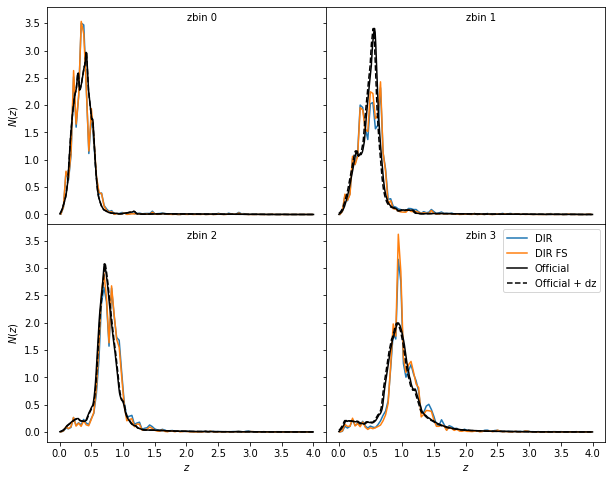

In [8]:
f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
print(f'Tracer name: Our <z> vs Our FS <z> vs Official <z> vs Official corrected by prior <z>')
for i in range(4):
    trn = f'DESwl__{i}'
    
    # COSMOS patch
    tr = sdir.tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR')
    zmean = np.sum(tr.nz * tr.z)/np.sum(tr.nz)
    
    # Full DES catalog
    tr = sdir_fs.tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR FS')
    zmean_fs = np.sum(tr.nz * tr.z)/np.sum(tr.nz)

    # Official Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    c = np.sum(nz) * (z[1] - z[0])
    zmean_official = np.sum(nz * z)/np.sum(nz)
    ax[i].plot(z, nz / c, color='k', label='Official')

    # Official Nz + dz
    dz, sdz = prior_official[trn]
    # Remove z's that will go negative after applying the shift dz
    nz = nz[z>= -dz]
    z = z[z>= -dz]
    z += dz
    ax[i].plot(z, nz / c, '--k', label='Official + dz')
    
    zmean_official_dz = np.sum(nz * z)/np.sum(nz)
    
    ax[i].text(0.5, 0.95, f'zbin {i}', horizontalalignment='left',
     verticalalignment='center', transform=ax[i].transAxes)
    
    print(f'{trn}: {zmean} vs {zmean_fs} vs {zmean_official} vs {zmean_official_dz}')

for i in range(2):
    ax[i+2].set_xlabel(r'$z$')
    ax[i*2].set_ylabel(r'$N(z)$')
    
plt.legend()
plt.show()
     

In [28]:
def get_z_of_chi(cosmo):
    a = np.logspace(0, -3, 1000)
    z = 1/a - 1
    chi = ccl.comoving_radial_distance(cosmo, a=a)
    return interp1d(chi, z)

cosmo = ccl.CosmologyVanillaLCDM()
z_of_chi = get_z_of_chi(cosmo)

f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
for i in range(4):
    trn = f'DESwl__{i}'
    
    # COSMOS patch
    tr = sdir.tracers[trn]
    chi, q = ccl.get_lensing_kernel(cosmo, (tr.z, tr.nz))
    ax[i].plot(z_of_chi(chi), q, label='DIR')
    
    # Full DES catalog
    tr = sdir_fs.tracers[trn]
    chi, q = ccl.get_lensing_kernel(cosmo, (tr.z, tr.nz))
    ax[i].plot(z_of_chi(chi), q, label='DIR FS')

    # Official Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    chi, q = ccl.get_lensing_kernel(cosmo, (z, nz))
    ax[i].plot(z_of_chi(chi), q, label='Official')

    # Official Nz + dz
    dz, sdz = prior_official[trn]
    # Remove z's that will go negative after applying the shift dz
    nz = nz[z>= -dz]
    z = z[z>= -dz]
    z += dz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    chi, q = ccl.get_lensing_kernel(cosmo, (z, nz))
    ax[i].plot(z_of_chi(chi), q, label='Official + dz')
        
    ax[i].text(0.5, 0.95, f'zbin {i}', horizontalalignment='left',
     verticalalignment='center', transform=ax[i].transAxes)
    
for i in range(2):
    ax[i+2].set_xlabel(r'$z$')
    ax[i*2].set_ylabel(r'$q(z)$')
    ax[i+2].set_xlim([None, 2])
plt.legend()
plt.show()

In [16]:
f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
print(f'Tracer name: Our <z> vs Our FS <z> vs Our FS riz <z> vs Our FS adjoint col <z> vs Our FS metacal R <z>  vs Official <z> vs Official corrected by prior <z>')
for i in range(4):
    trn = f'DESwl__{i}'
    
    # COSMOS patch
    tr = sdir.tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR')
    zmean = np.sum(tr.nz * tr.z)/np.sum(tr.nz)
    
    # Full DES catalog
    tr = sdir_fs.tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR FS')
    zmean_fs = np.sum(tr.nz * tr.z)/np.sum(tr.nz)
    
    # Full DES catalog + riz
    tr = saccs['fs_riz'].tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR FS riz')
    zmean_fs_riz = np.sum(tr.nz * tr.z)/np.sum(tr.nz)

    # Full DES catalog + adjoint
    tr = saccs['fs_adj'].tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR FS adjoint col')
    zmean_fs_adj = np.sum(tr.nz * tr.z)/np.sum(tr.nz)

    # Full DES catalog + metacal R
    tr = saccs['fs_metacal_R'].tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR FS metacal R')
    zmean_fs_metacal_R = np.sum(tr.nz * tr.z)/np.sum(tr.nz)
    
    # Official Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    c = np.sum(nz) * (z[1] - z[0])
    zmean_official = np.sum(nz * z)/np.sum(nz)
    ax[i].plot(z, nz / c, color='k', label='Official')

    # Official Nz + dz
    dz, sdz = prior_official[trn]
    # Remove z's that will go negative after applying the shift dz
    nz = nz[z>= -dz]
    z = z[z>= -dz]
    z += dz
    ax[i].plot(z, nz / c, '--k', label='Official + dz')
    
    zmean_official_dz = np.sum(nz * z)/np.sum(nz)
    
    ax[i].text(0.5, 0.95, f'zbin {i}', horizontalalignment='left',
     verticalalignment='center', transform=ax[i].transAxes)
    
    print(f'{trn}: {zmean:.4f} vs {zmean_fs:.4f} vs {zmean_fs_riz:.4f} vs {zmean_fs_adj:.4f} vs {zmean_fs_metacal_R:.4f} vs {zmean_official:.4f} vs {zmean_official_dz:.4f}')

for i in range(2):
    ax[i+2].set_xlabel(r'$z$')
    ax[i*2].set_ylabel(r'$N(z)$')
    
plt.legend()
plt.show()
     

Tracer name: Our <z> vs Our FS <z> vs Our FS riz <z> vs Our FS adjoint col <z> vs Our FS metacal R <z>  vs Official <z> vs Official corrected by prior <z>
DESwl__0: 0.4044 vs 0.3810 vs 0.3828 vs 0.4052 vs 0.3717 vs 0.3901 vs 0.3891
DESwl__1: 0.5538 vs 0.5226 vs 0.5232 vs 0.5561 vs 0.5063 vs 0.5262 vs 0.5073
DESwl__2: 0.8089 vs 0.7840 vs 0.7864 vs 0.8025 vs 0.7764 vs 0.7441 vs 0.7531
DESwl__3: 1.0386 vs 1.0149 vs 1.0113 vs 1.0379 vs 1.0080 vs 0.9675 vs 0.9497


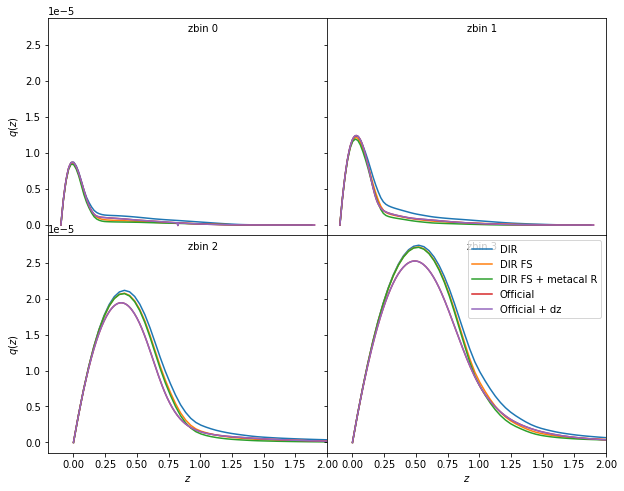

In [30]:
def get_z_of_chi(cosmo):
    a = np.logspace(0, -3, 1000)
    z = 1/a - 1
    chi = ccl.comoving_radial_distance(cosmo, a=a)
    return interp1d(chi, z)

cosmo = ccl.CosmologyVanillaLCDM()
z_of_chi = get_z_of_chi(cosmo)

f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
for i in range(4):
    trn = f'DESwl__{i}'
    
    # COSMOS patch
    tr = sdir.tracers[trn]
    chi, q = ccl.get_lensing_kernel(cosmo, (tr.z, tr.nz))
    ax[i].plot(z_of_chi(chi), q, label='DIR')
    
    # Full DES catalog
    tr = sdir_fs.tracers[trn]
    chi, q = ccl.get_lensing_kernel(cosmo, (tr.z, tr.nz))
    ax[i].plot(z_of_chi(chi), q, label='DIR FS')
    
    # Full DES catalog + metacal R
    tr = saccs['fs_metacal_R'].tracers[trn]
    chi, q = ccl.get_lensing_kernel(cosmo, (tr.z, tr.nz))
    ax[i].plot(z_of_chi(chi), q, label='DIR FS + metacal R')

    # Official Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    chi, q = ccl.get_lensing_kernel(cosmo, (z, nz))
    ax[i].plot(z_of_chi(chi), q, label='Official')

    # Official Nz + dz
    dz, sdz = prior_official[trn]
    # Remove z's that will go negative after applying the shift dz
    nz = nz[z>= -dz]
    z = z[z>= -dz]
    z += dz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    chi, q = ccl.get_lensing_kernel(cosmo, (z, nz))
    ax[i].plot(z_of_chi(chi), q, label='Official + dz')
        
    ax[i].text(0.5, 0.95, f'zbin {i}', horizontalalignment='left',
     verticalalignment='center', transform=ax[i].transAxes)
    
for i in range(2):
    ax[i+2].set_xlabel(r'$z$')
    ax[i*2].set_ylabel(r'$q(z)$')
    ax[i+2].set_xlim([None, 2])
plt.legend()
plt.show()

In [32]:
def get_z_of_chi(cosmo):
    a = np.logspace(0, -3, 1000)
    z = 1/a - 1
    chi = ccl.comoving_radial_distance(cosmo, a=a)
    return interp1d(chi, z)

cosmo = ccl.CosmologyVanillaLCDM()
z_of_chi = get_z_of_chi(cosmo)

f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
for i in range(4):
    trn = f'DESwl__{i}'
    
    # COSMOS patch
    tr = sdir.tracers[trn]
    chi, q = ccl.get_lensing_kernel(cosmo, (tr.z, tr.nz))
    ax[i].plot(z_of_chi(chi), q, label='DIR')

    # Full DES catalog + metacal R
    tr = saccs['fs_metacal_R'].tracers[trn]
    chi, q = ccl.get_lensing_kernel(cosmo, (tr.z, tr.nz))
    ax[i].plot(z_of_chi(chi), q, label='DIR FS + metacal R')
    
    # Shahab
    tr = saccs['shahab'].tracers[trn]
    chi, q = ccl.get_lensing_kernel(cosmo, (tr.z, tr.nz))
    ax[i].plot(z_of_chi(chi), q, label='Shahab Nz')
    
    # Official Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    chi, q = ccl.get_lensing_kernel(cosmo, (z, nz))
    ax[i].plot(z_of_chi(chi), q, label='Official')

#     # Official Nz + dz
#     dz, sdz = prior_official[trn]
#     # Remove z's that will go negative after applying the shift dz
#     nz = nz[z>= -dz]
#     z = z[z>= -dz]
#     z += dz
#     z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
#     chi, q = ccl.get_lensing_kernel(cosmo, (z, nz))
#     ax[i].plot(z_of_chi(chi), q, label='Official + dz')
        
    ax[i].text(0.5, 0.95, f'zbin {i}', horizontalalignment='left',
     verticalalignment='center', transform=ax[i].transAxes)
    
for i in range(2):
    ax[i+2].set_xlabel(r'$z$')
    ax[i*2].set_ylabel(r'$q(z)$')
    ax[i+2].set_xlim([None, 2])
plt.legend()
plt.show()

### DIR with less cuts in COSMOS and Full sample

Tracer name: Our FS <z> vs Our FS with new cuts in COSMOS <z> vs FS + NC + R vs Official <z> vs Official corrected by prior <z>
DESwl__0: 0.38104360353911476 vs 0.37776181261702335 vs 1.0046590994243334 vs 0.39005547135272084 vs 0.38905547135272084
DESwl__1: 0.5225926633064208 vs 0.5201404549863671 vs 1.0046590994243334 vs 0.5262341626576512 vs 0.507310659194213
DESwl__2: 0.7840478213373819 vs 0.782262514747082 vs 1.0046590994243334 vs 0.7441195872994767 vs 0.7531195872994767
DESwl__3: 1.0148881011704196 vs 1.0090705937274813 vs 1.0046590994243334 vs 0.9674512511446484 vs 0.9497019314399503


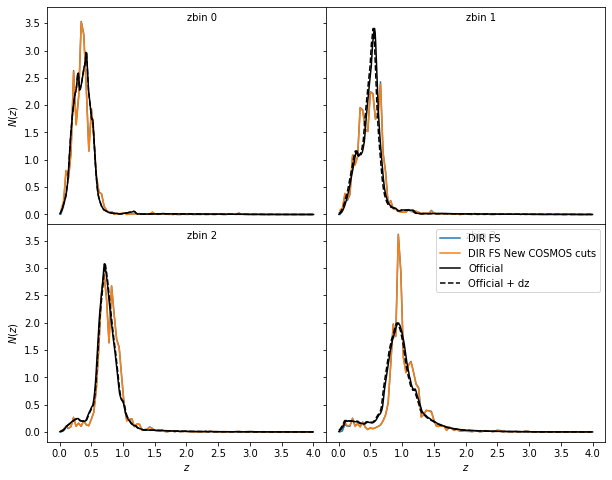

In [15]:
saccs['fs_newcuts'] = sacc.Sacc.load_fits('output/DES/DES_COSMOS15_less_cuts_maxd_1_nngh_20_griz_full_sample_nbins100_cls_covGNG_DIR.fits')
saccs['fs_newcuts_R'] = sacc.Sacc.load_fits('output/DES/DES_COSMOS15_less_cuts_R_maxd_1_nngh_20_griz_full_sample_nbins100_cls_covGNG_DIR.fits')


f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
print(f'Tracer name: Our FS <z> vs Our FS with new cuts in COSMOS <z> vs FS + NC + R vs Official <z> vs Official corrected by prior <z>')
for i in range(4):
    trn = f'DESwl__{i}'
    
    # Full DES catalog
    tr = sdir_fs.tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR FS')
    zmean_fs = np.sum(tr.nz * tr.z)/np.sum(tr.nz)

    # Full DES catalog
    tr = saccs['fs_newcuts'].tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR FS New COSMOS cuts')
    zmean_fs_nc = np.sum(tr.nz * tr.z)/np.sum(tr.nz)    
    
    # Official Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    c = np.sum(nz) * (z[1] - z[0])
    zmean_official = np.sum(nz * z)/np.sum(nz)
    ax[i].plot(z, nz / c, color='k', label='Official')

    # Official Nz + dz
    dz, sdz = prior_official[trn]
    # Remove z's that will go negative after applying the shift dz
    nz = nz[z>= -dz]
    z = z[z>= -dz]
    z += dz
    ax[i].plot(z, nz / c, '--k', label='Official + dz')
    
    zmean_official_dz = np.sum(nz * z)/np.sum(nz)
    
    ax[i].text(0.5, 0.95, f'zbin {i}', horizontalalignment='left',
     verticalalignment='center', transform=ax[i].transAxes)
    
    print(f'{trn}: {zmean_fs} vs {zmean_fs_nc} vs {zmean_fs_nc_R} vs {zmean_official} vs {zmean_official_dz}')

for i in range(2):
    ax[i+2].set_xlabel(r'$z$')
    ax[i*2].set_ylabel(r'$N(z)$')
    
plt.legend()
plt.show()
     

Tracer name: Our FS <z> vs FS + fixed R vs Official <z> vs Official corrected by prior <z>
DESwl__0: 0.3717194583145683 vs 0.3699006628357982 vs 0.39005547135272084 vs 0.38905547135272084
DESwl__1: 0.5062540175663707 vs 0.5037804399478524 vs 0.5262341626576512 vs 0.507310659194213
DESwl__2: 0.7763710849632749 vs 0.7740353870281055 vs 0.7441195872994767 vs 0.7531195872994767
DESwl__3: 1.0080105653048097 vs 1.0046590994243334 vs 0.9674512511446484 vs 0.9497019314399503


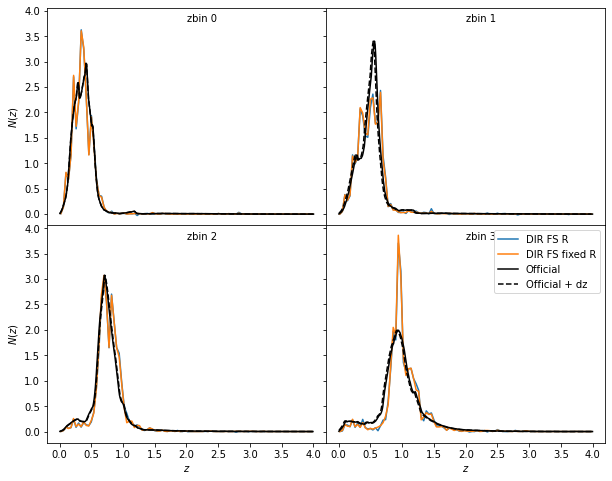

In [14]:
saccs['fs_fixedR'] = sacc.Sacc.load_fits('output/DES/DES_COSMOS15_R_maxd_1_nngh_20_griz_full_sample_nbins100_cls_covGNG_DIR.fits')


f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
print(f'Tracer name: Our FS <z> vs FS + fixed R vs Official <z> vs Official corrected by prior <z>')
for i in range(4):
    trn = f'DESwl__{i}'
    
    # Full DES catalog
    tr = saccs['fs_metacal_R'].tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR FS R')
    zmean_fs = np.sum(tr.nz * tr.z)/np.sum(tr.nz)

    # Full DES catalog
    tr = saccs['fs_fixedR'].tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR FS fixed R')
    zmean_fs_R = np.sum(tr.nz * tr.z)/np.sum(tr.nz)    
    
    # Official Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    c = np.sum(nz) * (z[1] - z[0])
    zmean_official = np.sum(nz * z)/np.sum(nz)
    ax[i].plot(z, nz / c, color='k', label='Official')

    # Official Nz + dz
    dz, sdz = prior_official[trn]
    # Remove z's that will go negative after applying the shift dz
    nz = nz[z>= -dz]
    z = z[z>= -dz]
    z += dz
    ax[i].plot(z, nz / c, '--k', label='Official + dz')
    
    zmean_official_dz = np.sum(nz * z)/np.sum(nz)
    
    ax[i].text(0.5, 0.95, f'zbin {i}', horizontalalignment='left',
     verticalalignment='center', transform=ax[i].transAxes)
    
    print(f'{trn}: {zmean_fs} vs {zmean_fs_R} vs {zmean_official} vs {zmean_official_dz}')

for i in range(2):
    ax[i+2].set_xlabel(r'$z$')
    ax[i*2].set_ylabel(r'$N(z)$')
    
plt.legend()
plt.show()
     

### DES cosmology patch (+ COSMOS15)

In [16]:
saccs['cosmo_patch_R'] = sacc.Sacc.load_fits('output/DES/DES_COSMOS15_R_maxd_1_nngh_20_griz_cosmo_patch_nbins100_cls_covGNG_DIR.fits')

In [23]:
f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
print(f'Tracer name: Our FS + R <z> vs cosmo-patch vs Official + R <z> vs Official corrected by prior <z>')
for i in range(4):
    trn = f'DESwl__{i}'
    
#     # COSMOS patch
#     tr = sdir.tracers[trn]
#     c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
#     ax[i].plot(tr.z, tr.nz / c, label='DIR')
#     zmean = np.sum(tr.nz * tr.z)/np.sum(tr.nz)
    
    # Full DES catalog
    tr = saccs['fs_metacal_R'].tracers[trn]
    tr = sdir_fs.tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR FS R')
    zmean_fs = np.sum(tr.nz * tr.z)/np.sum(tr.nz)
    
    # Full DES catalog
    tr = saccs['cosmo_patch_R'].tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='Cosmology patch')
    zmean_cosmo_patch_R = np.sum(tr.nz * tr.z)/np.sum(tr.nz)

    # Official Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    c = np.sum(nz) * (z[1] - z[0])
    zmean_official = np.sum(nz * z)/np.sum(nz)
    ax[i].plot(z, nz / c, color='k', label='Official')

    # Official Nz + dz
    dz, sdz = prior_official[trn]
    # Remove z's that will go negative after applying the shift dz
    nz = nz[z>= -dz]
    z = z[z>= -dz]
    z += dz
    ax[i].plot(z, nz / c, '--k', label='Official + dz')
    
    zmean_official_dz = np.sum(nz * z)/np.sum(nz)
    
    ax[i].text(0.5, 0.95, f'zbin {i}', horizontalalignment='left',
     verticalalignment='center', transform=ax[i].transAxes)
    
    print(f'{trn}: {zmean_fs} vs {zmean_cosmo_patch_R} vs {zmean_official} vs {zmean_official_dz}')

for i in range(2):
    ax[i+2].set_xlabel(r'$z$')
    ax[i*2].set_ylabel(r'$N(z)$')
    
plt.legend()
plt.show()
     

Tracer name: Our FS + R <z> vs cosmo-patch vs Official + R <z> vs Official corrected by prior <z>
DESwl__0: 0.38104360353911476 vs 0.3832815388844123 vs 0.39005547135272084 vs 0.38905547135272084
DESwl__1: 0.5225926633064208 vs 0.5222543150361225 vs 0.5262341626576512 vs 0.507310659194213
DESwl__2: 0.7840478213373819 vs 0.7949879088733867 vs 0.7441195872994767 vs 0.7531195872994767
DESwl__3: 1.0148881011704196 vs 1.0267184576566322 vs 0.9674512511446484 vs 0.9497019314399503


Tracer name: Our FS + R <z> vs cosmo-patch vs Official + R <z> vs Official corrected by prior <z>
DESwl__0: 1.0148881011704196 vs 0.3832815388844123 vs 0.39005547135272084 vs 0.38905547135272084
DESwl__1: 1.0148881011704196 vs 0.5222543150361225 vs 0.5262341626576512 vs 0.507310659194213
DESwl__2: 1.0148881011704196 vs 0.7949879088733867 vs 0.7441195872994767 vs 0.7531195872994767
DESwl__3: 1.0148881011704196 vs 1.0267184576566322 vs 0.9674512511446484 vs 0.9497019314399503


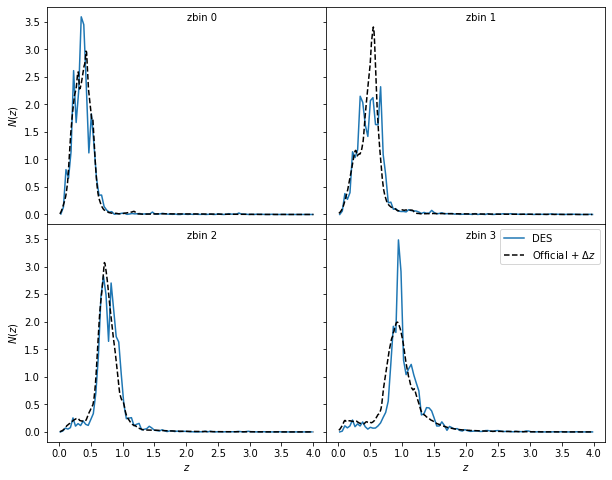

In [24]:
f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
print(f'Tracer name: Our FS + R <z> vs cosmo-patch vs Official + R <z> vs Official corrected by prior <z>')
for i in range(4):
    trn = f'DESwl__{i}'
    
#     # COSMOS patch
#     tr = sdir.tracers[trn]
#     c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
#     ax[i].plot(tr.z, tr.nz / c, label='DIR')
#     zmean = np.sum(tr.nz * tr.z)/np.sum(tr.nz)
    
    # Full DES catalog
#     tr = saccs['fs_metacal_R'].tracers[trn]
#     tr = sdir_fs.tracers[trn]
#     c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
#     ax[i].plot(tr.z, tr.nz / c, label='DIR FS R')
#     zmean_fs = np.sum(tr.nz * tr.z)/np.sum(tr.nz)
    
    # Full DES catalog
    tr = saccs['cosmo_patch_R'].tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DES')
    zmean_cosmo_patch_R = np.sum(tr.nz * tr.z)/np.sum(tr.nz)

    # Official Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    c = np.sum(nz) * (z[1] - z[0])
    zmean_official = np.sum(nz * z)/np.sum(nz)
#     ax[i].plot(z, nz / c, color='k', label='Official')

    # Official Nz + dz
    dz, sdz = prior_official[trn]
    # Remove z's that will go negative after applying the shift dz
    nz = nz[z>= -dz]
    z = z[z>= -dz]
    z += dz
    ax[i].plot(z, nz / c, '--k', label='Official + $\Delta z$')
    
    zmean_official_dz = np.sum(nz * z)/np.sum(nz)
    
    ax[i].text(0.5, 0.95, f'zbin {i}', horizontalalignment='left',
     verticalalignment='center', transform=ax[i].transAxes)
    
    print(f'{trn}: {zmean_fs} vs {zmean_cosmo_patch_R} vs {zmean_official} vs {zmean_official_dz}')

for i in range(2):
    ax[i+2].set_xlabel(r'$z$')
    ax[i*2].set_ylabel(r'$N(z)$')
    
plt.legend()
plt.show()
     

### PAU vs COSMOS15 vs Official

In [8]:
sdir_PAU = sacc.Sacc.load_fits('data/DESwl_full_sample_cls_NzMarg_cov_p5.0_area2_diag1.fits')

f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
for i in range(4):
    trn = f'DESwl__{i}'
    
    tr = sdir.tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR (COSMOS15)')

    # New version (should match the previous ones)
    tr = sdir_PAU.tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, '--', label='DIR (PAU)') 
    
    # Oficial Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    c = np.sum(nz) * (z[1] - z[0])
    ax[i].plot(z, nz / c, color='k', label='Official')
    
    ax[i].set_xlabel('z')
    ax[i].set_ylabel('Nz')
    ax[i].set_title(f'zbin {i}')
plt.legend()
plt.show()
     

In [60]:
f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
print(f'Tracer name: Our <z> vs PAU <z> vs PAU FS R <z> vs Official corrected by prior <z>')
dir_shift = {}
for i in range(4):
    trn = f'DESwl__{i}'
    tr = sdir.tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR')
    zmean = np.sum(tr.nz * tr.z)/np.sum(tr.nz)

    # PAU
    tr = saccs['PAU'].tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, '--', label='DIR (PAU)') 
    zmean_PAU = np.sum(tr.nz * tr.z)/np.sum(tr.nz)
    
    # PAU + FS + R
    tr = saccs['PAU_fs_R'].tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, '--', label='DIR (PAU) + FS + R') 
    zmean_PAU_fs_R = np.sum(tr.nz * tr.z)/np.sum(tr.nz)
    
    # Official Nz + dz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    dz, sdz = prior_official[trn]
    # Remove z's that will go negative after applying the shift dz
    nz = nz[z>= -dz]
    z = z[z>= -dz]
    z += dz
    c = np.sum(nz) * (z[1] - z[0])
    ax[i].plot(z, nz / c, '--k', label='Official + dz')
    zmean_official_dz = np.sum(nz * z)/np.sum(nz)
    
    ax[i].text(0.5, 0.95, f'zbin {i}', horizontalalignment='left',
     verticalalignment='center', transform=ax[i].transAxes)
    
    dir_shift[trn] = zmean_official_dz - zmean
    print(f'{trn}: {zmean} vs {zmean_PAU} vs {zmean_PAU_fs_R} vs {zmean_official_dz} || dz = {dir_shift[trn]}')

for i in range(2):
    ax[i+2].set_xlabel(r'$z$')
    ax[i*2].set_ylabel(r'$N(z)$')
    
plt.legend()
plt.show()
     

Tracer name: Our <z> vs PAU <z> vs PAU FS R <z> vs Official corrected by prior <z>
DESwl__0: 0.4044145809119732 vs 0.37636194125421335 vs 0.3673603273426385 vs 0.38905547135272084 || dz = -0.015359109559252349
DESwl__1: 0.5538383777636466 vs 0.5201111468113718 vs 0.5065535957181725 vs 0.507310659194213 || dz = -0.04652771856943361
DESwl__2: 0.8089056801708394 vs 0.7961112768234696 vs 0.7773930771090113 vs 0.7531195872994767 || dz = -0.055786092871362714
DESwl__3: 1.038554883058279 vs 0.9737795275590551 vs 0.9866425364779224 vs 0.9497019314399503 || dz = -0.08885295161832862


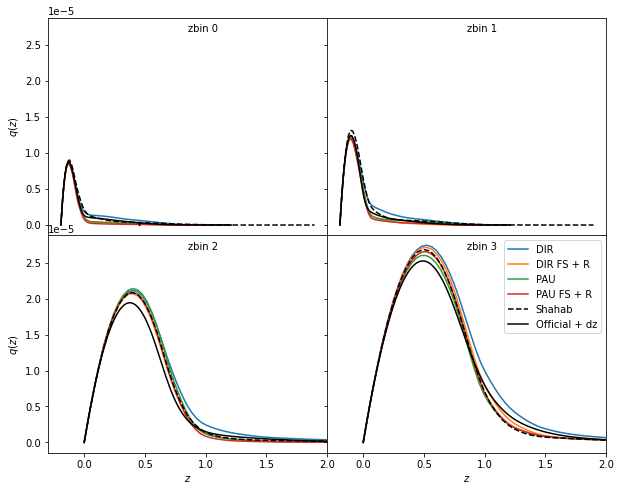

In [8]:
def get_z_of_chi(cosmo):
    a = np.logspace(0, -3, 1000)
    z = 1/a - 1
    chi = ccl.comoving_radial_distance(cosmo, a=a)
    return interp1d(chi, z)

cosmo = ccl.CosmologyVanillaLCDM()
z_of_chi = get_z_of_chi(cosmo)

f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
for i in range(4):
    trn = f'DESwl__{i}'
    
    # COSMOS patch
    tr = sdir.tracers[trn]
    chi, q = ccl.get_lensing_kernel(cosmo, (tr.z, tr.nz))
    ax[i].plot(z_of_chi(chi), q, label='DIR')
    
    # Full DES catalog
    tr = saccs['fs_metacal_R'].tracers[trn]
    chi, q = ccl.get_lensing_kernel(cosmo, (tr.z, tr.nz))
    ax[i].plot(z_of_chi(chi), q, label='DIR FS + R')
    
    # PAU
    tr = saccs['PAU'].tracers[trn]
    chi, q = ccl.get_lensing_kernel(cosmo, (tr.z, tr.nz))
    ax[i].plot(z_of_chi(chi), q, label='PAU')

    # PAU + FS + R
    tr = saccs['PAU_fs_R'].tracers[trn]
    chi, q = ccl.get_lensing_kernel(cosmo, (tr.z, tr.nz))
    ax[i].plot(z_of_chi(chi), q, label='PAU FS + R')    

    # PAU + FS + R
    tr = saccs['shahab'].tracers[trn]
    chi, q = ccl.get_lensing_kernel(cosmo, (tr.z, tr.nz))
    ax[i].plot(z_of_chi(chi), q, '--k', label='Shahab')

    # Official Nz + dz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    dz, sdz = prior_official[trn]
    # Remove z's that will go negative after applying the shift dz
    nz = nz[z>= -dz]
    z = z[z>= -dz]
    z += dz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    chi, q = ccl.get_lensing_kernel(cosmo, (z, nz))
    ax[i].plot(z_of_chi(chi), q, color='k',label='Official + dz')
        
    ax[i].text(0.5, 0.95, f'zbin {i}', horizontalalignment='left',
     verticalalignment='center', transform=ax[i].transAxes)
    
for i in range(2):
    ax[i+2].set_xlabel(r'$z$')
    ax[i*2].set_ylabel(r'$q(z)$')
    ax[i+2].set_xlim([None, 2])
plt.legend()
plt.show()

### David's

In [9]:
Nz_david = np.load(f'output/DES/nz_DIR_DESY1_david.npz')

In [10]:
f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
for i in range(4):
    trn = f'DESwl__{i}'
    # Removed flagged galaxies (as in DES papers and our mapper)
    tr = sdir.tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR (Carlos)')

    # Kept flagged galaxies
#     tr = sdir_noflag.tracers[trn]
#     c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
#     ax[i].plot(tr.z, tr.nz / c, label='DIR (kept flagged)') 

    # Oficial Nz
    z, nz = Nz_david['z_edges'], Nz_david[f'nz_bin{i}']
    c = np.sum(nz) * (z[1] - z[0])
    ax[i].plot((z[1:] + z[:-1]) / 2, nz / c, '--', label='DIR (David)')

    # Oficial Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    c = np.sum(nz) * (z[1] - z[0])
    ax[i].plot(z, nz / c, color='k', label='Official')
    
    ax[i].set_xlabel('z')
    ax[i].set_ylabel('Nz')
    ax[i].set_title(f'zbin {i}')
plt.legend()
plt.show()
     

KeyboardInterrupt: 

### With R

In [ ]:
    nzf = np.loadtxt(f'output/DES/desnz_recalresponse_rs_{i+1}.dat')


In [ ]:
f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
for i in range(4):
    trn = f'DESwl__{i}'
    # Production
    tr = sdir.tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR') 
    
#     #With metacal R
#     nzf = np.load(f'output/DES/DES_R_maxd_1_nngh_20_nbins100_bin{i}_Nz.npz')
#     ax[i].plot((nzf['z'][1:] + nzf['z'][:-1]) / 2., nzf['Nz'], '--', label=f'DIR (with metacal R)')

    # Shahab
    z, nz = np.loadtxt(f'output/DES/desnz_recalresponse_rs_{i+1}.dat', unpack=True)
    ax[i].plot(z, nz, '-.', label=f'DIR (Shahab)')
    
    # Oficial Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    c = np.sum(nz) * (z[1] - z[0])
    ax[i].plot(z, nz / c, color='k', label='Official')
    
    ax[i].set_xlabel('z')
    ax[i].set_ylabel('Nz')
    ax[i].set_title(f'zbin {i}')
    ax[i].set_xlim([None, 2])
plt.legend()
plt.show()
     

### Different zbins, nneigh, maxd

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
for i in range(4):
    trn = f'DESwl__{i}'
    # Production
    tr = sdir.tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR (default, maxd 1 nngh 20)')
    
    # Change nneigh
#     for nn in ['10', '40']:
#         nzf = np.load(f'output/DES_changing_confs/DES__maxd_1.0_nngh_{nn}_bin{i}_Nz.npz')
#         ax[i].plot((nzf['z'][1:] + nzf['z'][:-1]) / 2., nzf['Nz'], label=f'DIR (maxd 1, nngh {nn})')
    
    # Change max_distance
    for maxd in ['0.05', '0.1', '0.5', '2.0']:
        nzf = np.load(f'output/DES_changing_confs/DES__maxd_{maxd}_nngh_20_bin{i}_Nz.npz')
        ax[i].plot((nzf['z'][1:] + nzf['z'][:-1]) / 2., nzf['Nz'], label=f'DIR (maxd {maxd}, nngh 20)')
        
    # Oficial Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    c = np.sum(nz) * (z[1] - z[0])
    ax[i].plot(z, nz / c, color='k', label='Official')
    
    ax[i].set_xlabel('z')
    ax[i].set_ylabel('Nz')
    ax[i].set_title(f'zbin {i}')
plt.legend()
plt.show()
     

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
for i in range(4):
    trn = f'DESwl__{i}'
    # Production
    tr = sdir.tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR (default, maxd 1 nngh 20)')
    
    # Change nneigh
    for nn in ['5', '10', '40', '60']:
        nzf = np.load(f'output/DES_changing_confs/DES__maxd_1.0_nngh_{nn}_bin{i}_Nz.npz')
        ax[i].plot((nzf['z'][1:] + nzf['z'][:-1]) / 2., nzf['Nz'], label=f'DIR (maxd 1, nngh {nn})')
    
    # Change max_distance
#     for maxd in ['0.05', '0.1', '0.5', '2.0']:
#         nzf = np.load(f'output/DES_changing_confs/DES__maxd_{maxd}_nngh_20_bin{i}_Nz.npz')
#         ax[i].plot((nzf['z'][1:] + nzf['z'][:-1]) / 2., nzf['Nz'], label=f'DIR (maxd {maxd}, nngh 20)')
        
    # Oficial Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    c = np.sum(nz) * (z[1] - z[0])
    ax[i].plot(z, nz / c, color='k', label='Official')
    
    ax[i].set_xlabel('z')
    ax[i].set_ylabel('Nz')
    ax[i].set_title(f'zbin {i}')
plt.legend()
plt.show()
     

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
for i in range(4):
    trn = f'DESwl__{i}'
    # Production
    tr = sdir.tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR (default, maxd 1 nngh 20)')
    
    # Change
    for nb in ['20', '30', '40']:
        nzf = np.load(f'output/DES_changing_confs/DES__maxd_1_nngh_20_nbins{nb}_bin{i}_Nz.npz')
        ax[i].plot((nzf['z'][1:] + nzf['z'][:-1]) / 2., nzf['Nz'], label=f'DIR ({nb} zbins)')
    
    # Oficial Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    c = np.sum(nz) * (z[1] - z[0])
    ax[i].plot(z, nz / c, color='k', label='Official')
    
    ax[i].set_xlabel('z')
    ax[i].set_ylabel('Nz')
    ax[i].set_title(f'zbin {i}')
plt.legend()
plt.show()
     

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
for i in range(4):
    trn = f'DESwl__{i}'
    # Production
    tr = sdir.tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR (default, maxd 1 nngh 20)')
    
    # Change
    for nb in ['20', '30']:
        nzf = np.load(f'output/DES_changing_confs/DES__maxd_1_nngh_20_nbins{nb}_bin{i}_Nz.npz')
        ax[i].plot((nzf['z'][1:] + nzf['z'][:-1]) / 2., nzf['Nz'], label=f'DIR ({nb} zbins)')
    
    # Oficial Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    c = np.sum(nz) * (z[1] - z[0])
    ax[i].plot(z, nz / c, color='k', label='Official')
    
    ax[i].set_xlabel('z')
    ax[i].set_ylabel('Nz')
    ax[i].set_title(f'zbin {i}')
plt.legend()
plt.show()
     

### Adjoint color space

In [ ]:
xmat = np.load('output/DES/DES_short_cat_pix_xmat.npz')

In [ ]:
list(xmat.keys())

In [ ]:
wa = np.load(f'output/DES/DES_bin0_weights.npz')['W_a']
plt.hist(wa*10000, bins=20, histtype='step')
# wa = np.load(f'output/DES_changing_confs/DES_w1_maxd_1_nngh_20_nbins100_bin0_weights.npz')['W_a']
# plt.hist(wa, bins=20, histtype='step')
wa = np.load(f'output/DES_3band_maxd_1_nngh_20_nbins100_bin0_weights.npz')['W_a']
plt.hist(wa*10000, bins=20, histtype='step')


In [ ]:
f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
for i in range(4):
    trn = f'DESwl__{i}'
    # Production
    tr = sdir.tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR (color space)')
    
    # Adjoint
    nzf = np.load(f'output/DES_3band_maxd_1_nngh_20_nbins100_bin{i}_Nz.npz')
    ax[i].plot((nzf['z'][1:] + nzf['z'][:-1]) / 2., nzf['Nz'], label=f'DIR (3rd)')    
    
    # Adjoint + r
    nzf = np.load(f'output/DES_changing_confs/DES_w1_maxd_1_nngh_20_nbins100_bin{i}_Nz.npz')
    ax[i].plot((nzf['z'][1:] + nzf['z'][:-1]) / 2., nzf['Nz'], label=f'DIR (weights 1)')
    
    # Oficial Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    c = np.sum(nz) * (z[1] - z[0])
    ax[i].plot(z, nz / c, color='k', label='Official')
    
    ax[i].set_xlabel('z')
    ax[i].set_ylabel('Nz')
    ax[i].set_title(f'zbin {i}')
plt.legend()
plt.show()
     

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
for i in range(4):
    trn = f'DESwl__{i}'
    # Production
    tr = sdir.tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, label='DIR (color space)')
    
    # Adjoint
    nzf = np.load(f'output/DES_changing_confs/DES__maxd_1_nngh_20_adjoint_colors_nbins100_bin{i}_Nz.npz')
    ax[i].plot((nzf['z'][1:] + nzf['z'][:-1]) / 2., nzf['Nz'], label=f'DIR (adjoint color space)')    
    
    # Adjoint + r
    nzf = np.load(f'output/DES_changing_confs/DES__maxd_1_nngh_20_adjoint_colors_plus_flux_r_nbins100_bin{i}_Nz.npz')
    ax[i].plot((nzf['z'][1:] + nzf['z'][:-1]) / 2., nzf['Nz'], label=f'DIR (adjoint color space + r)')
    
    # Oficial Nz
    z, nz = Nz_official['Z_MID'], Nz_official[f'BIN{i+1}']
    c = np.sum(nz) * (z[1] - z[0])
    ax[i].plot(z, nz / c, color='k', label='Official')
    
    ax[i].set_xlabel('z')
    ax[i].set_ylabel('Nz')
    ax[i].set_title(f'zbin {i}')
plt.legend()
plt.show()
     

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
for i in range(4):
    trn = f'DESwl__{i}'
    # Production
    nzf = np.load(f'output/DES/DES_bin{i}_Nz.npz')
#     ax[i].plot((nzf['z'][1:] + nzf['z'][:-1]) / 2., nzf['Nz'], label=f'DIR')    
    
    # Adjoint
    nzf2 = np.load(f'output/DES_changing_confs/DES__maxd_1_nngh_20_adjoint_colors_nbins100_bin{i}_Nz.npz')
    ax[i].plot((nzf['z'][1:] + nzf['z'][:-1]) / 2., nzf2['Nz']/nzf['Nz'] - 1,
               label=f'DIR (adjoint color space)')    
    
    # Adjoint + r
    nzf2 = np.load(f'output/DES_changing_confs/DES__maxd_1_nngh_20_adjoint_colors_plus_flux_r_nbins100_bin{i}_Nz.npz')
    ax[i].plot((nzf['z'][1:] + nzf['z'][:-1]) / 2., nzf2['Nz']/nzf['Nz'] - 1,
               label=f'DIR (adjoint color space + r)')
    
    # Adjoint + r
    nzf2 = np.load(f'output/DES_changing_confs/DES_w1_maxd_1_nngh_20_nbins100_bin{i}_Nz.npz')
    ax[i].plot((nzf['z'][1:] + nzf['z'][:-1]) / 2., nzf2['Nz']/nzf['Nz'] - 1,
               label=f'DIR (adjoint color space + r)')
        
    ax[i].set_xlabel('z')
    ax[i].set_ylabel('Nz / Nz_color_space - 1')
    ax[i].set_title(f'zbin {i}')
plt.legend()
plt.show()
     

### Catalog exploration

In [ ]:
cat = fitsio.read('/mnt/extraspace/gravityls_3/data/DESY1/y1_metacal_flux_griz_release_short_COSMOS.fits')

In [ ]:
cat['R']

In [ ]:
for col in cat.dtype.names:
    sel = cat[col] > 0
    cat = cat[sel]
    cat[col] = np.log10(cat[col])

In [ ]:
plt.hist([cat[col] for col in cat.dtype.names], histtype='step', bins=100, density=True);

In [ ]:
plt.hexbin(cat['flux_g']- cat['flux_r'], cat['flux_r'] - cat['flux_i'])

### Color space histograms

In [33]:
photo_columns_sky = ['ra', 'dec']
photo_columns_mag = ['mag_g', 'mag_r', 'mag_i', 'mag_z']
photo_columns_zbin = ['zbin_mcal']

photo_sample = fitsio.read('/mnt/extraspace/gravityls_3/data/DESY1/DESY1wl_short_for_DIR_with_COSMOS15.fits')
pcat_xmat = fitsio.read('/mnt/extraspace/gravityls_3/data/DESY1/DESY1wl_xmatch_with_COSMOS15.fits')
scat_xmat = fitsio.read('/mnt/extraspace/gravityls_3/data/DESY1/COSMOS15_xmatch_with_DESY1wl.fits')

photo_sample_full = fitsio.read('/mnt/extraspace/gravityls_3/data/DESY1/DESY1wl_short_for_DIR_with_full_sample.fits')
sel = photo_sample_full['dec'] > -90
sel *= photo_sample_full['dec'] < -35
photo_sample_full_rec = photo_sample_full[sel]

In [40]:
scat_xmat.dtype.names

('ALPHA_J2000',
 'DELTA_J2000',
 'NUMBER',
 'X_IMAGE',
 'Y_IMAGE',
 'ERRX2_IMAGE',
 'ERRY2_IMAGE',
 'ERRXY_IMAGE',
 'FLAG_HJMCC',
 'FLUX_RADIUS',
 'KRON_RADIUS',
 'EBV',
 'FLAG_PETER',
 'FLAG_COSMOS',
 'FLAG_DEEP',
 'FLAG_SHALLOW',
 'Ks_FLUX_APER2',
 'Ks_FLUXERR_APER2',
 'Ks_FLUX_APER3',
 'Ks_FLUXERR_APER3',
 'Ks_MAG_APER2',
 'Ks_MAGERR_APER2',
 'Ks_MAG_APER3',
 'Ks_MAGERR_APER3',
 'Ks_MAG_AUTO',
 'Ks_MAGERR_AUTO',
 'Ks_MAG_ISO',
 'Ks_MAGERR_ISO',
 'Ks_FLAGS',
 'Ks_IMAFLAGS_ISO',
 'Y_FLUX_APER2',
 'Y_FLUXERR_APER2',
 'Y_FLUX_APER3',
 'Y_FLUXERR_APER3',
 'Y_MAG_APER2',
 'Y_MAGERR_APER2',
 'Y_MAG_APER3',
 'Y_MAGERR_APER3',
 'Y_MAG_AUTO',
 'Y_MAGERR_AUTO',
 'Y_MAG_ISO',
 'Y_MAGERR_ISO',
 'Y_FLAGS',
 'Y_IMAFLAGS_ISO',
 'H_FLUX_APER2',
 'H_FLUXERR_APER2',
 'H_FLUX_APER3',
 'H_FLUXERR_APER3',
 'H_MAG_APER2',
 'H_MAGERR_APER2',
 'H_MAG_APER3',
 'H_MAGERR_APER3',
 'H_MAG_AUTO',
 'H_MAGERR_AUTO',
 'H_MAG_ISO',
 'H_MAGERR_ISO',
 'H_FLAGS',
 'H_IMAFLAGS_ISO',
 'J_FLUX_APER2',
 'J_FLUXERR_APER2',


In [47]:
col = 'ip_MAG_ISO'
ix = np.argmax(scat_xmat[col])
print(scat_xmat['PHOTOZ'][ix], scat_xmat[col][ix])

0.91 99.0


In [51]:
print(np.sum(scat_xmat['ip_MAG_ISO'] == 99), 'out of', scat_xmat.shape)

19 out of (25301,)


In [42]:
scat_xmat['r_MAG_ISO'].max(), scat_xmat['r_MAG_AUTO'].max(), scat_xmat['r_MAG_APER2'].max()

(99.0, 99.0, 26.647999)

Selecting galaxies in zbin 0


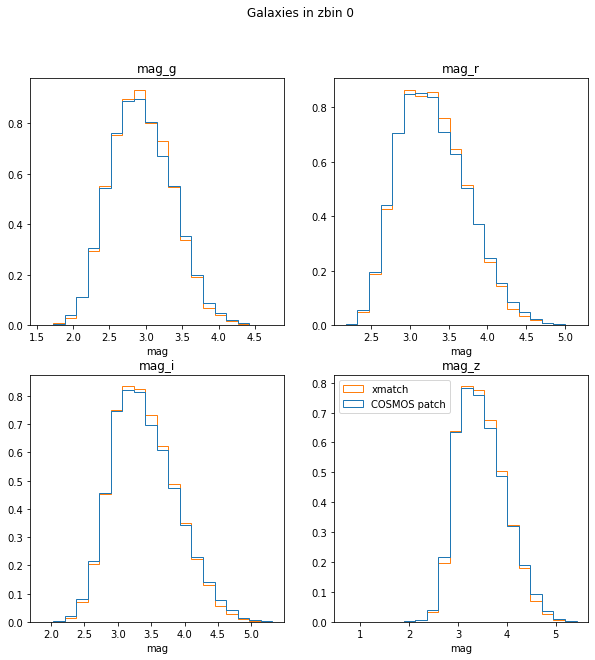

Selecting galaxies in zbin 1


Selecting galaxies in zbin 2


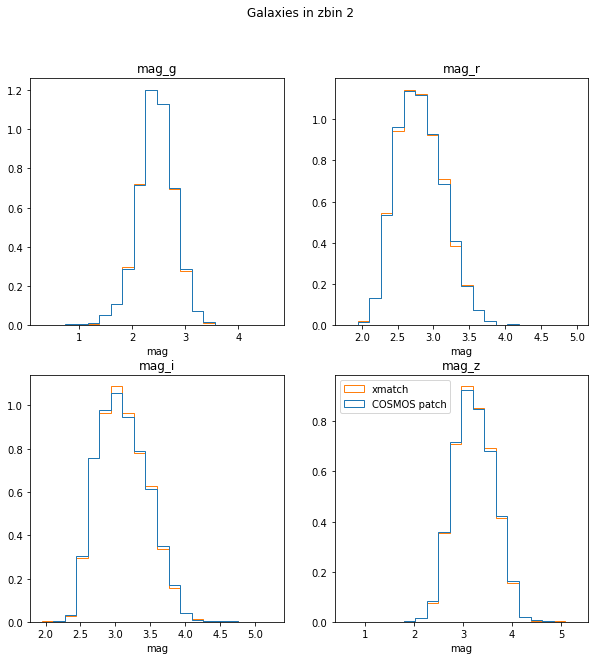

Selecting galaxies in zbin 3


In [63]:
for zbin in range(4):
    print(f'Selecting galaxies in zbin {zbin}', flush=True)
    # Based on https://github.com/xC-ell/xCell/blob/b00b448d18880afc3b405f939a7aabd934df45be/xcell/mappers/mapper_DESY1wl.py#L92-L96
    sel = photo_sample['zbin_mcal'] == zbin
    sel_xmat = pcat_xmat['zbin_mcal'] == zbin
    
    f, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax = ax.reshape(-1)
    for i, c in enumerate(photo_columns_mag):
        ax[i].hist([photo_sample[sel][c], pcat_xmat[sel_xmat][c]],
                   histtype='step',
                   label=['COSMOS patch', 'xmatch'],
                   bins=20, density=True)
        ax[i].set_title(c)
        ax[i].set_xlabel('mag')
    ax[i].legend(loc='upper left')
    f.suptitle(f'Galaxies in zbin {zbin}')
    plt.show()
    plt.close()

Selecting galaxies in zbin 0


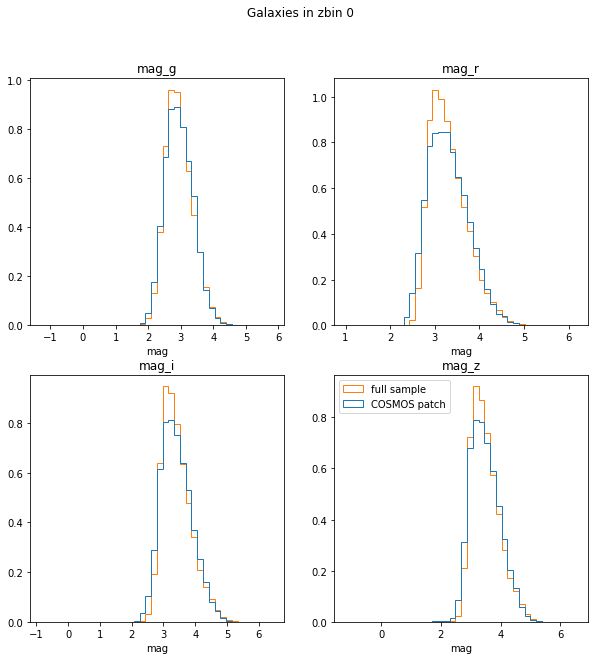

Selecting galaxies in zbin 1


Selecting galaxies in zbin 2


Selecting galaxies in zbin 3


In [64]:
for zbin in range(4):
    print(f'Selecting galaxies in zbin {zbin}', flush=True)
    # Based on https://github.com/xC-ell/xCell/blob/b00b448d18880afc3b405f939a7aabd934df45be/xcell/mappers/mapper_DESY1wl.py#L92-L96
    sel = photo_sample_zbin['zbin_mcal'] == zbin
    sel_xmat = photo_sample_zbin[pix_xmat]['zbin_mcal'] == zbin
    
    sel_full = photo_sample_full['zbin_mcal'] == zbin

    f, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax = ax.reshape(-1)
    for i, c in enumerate(photo_columns_mag):
        ax[i].hist([photo_sample[sel][c], photo_sample_full[sel_full][c]],
                   histtype='step',
                   label=['COSMOS patch', 'full sample'],
                   bins=40, density=True)
        ax[i].set_title(c)
        ax[i].set_xlabel('mag')
    ax[i].legend(loc='upper left')
    f.suptitle(f'Galaxies in zbin {zbin}')
    plt.show()
    plt.close()

Selecting galaxies in zbin 0


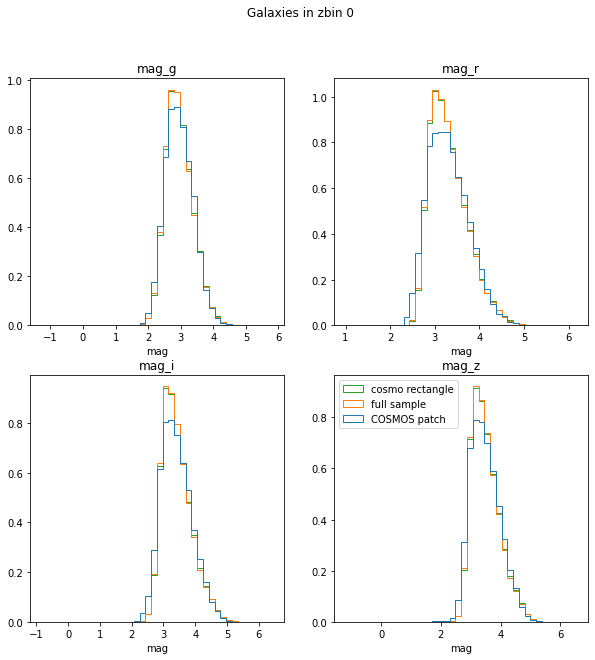

Selecting galaxies in zbin 1


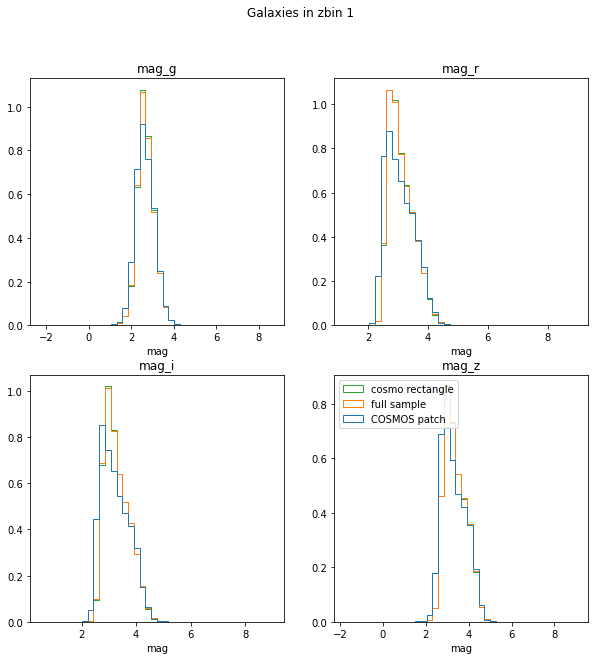

Selecting galaxies in zbin 2


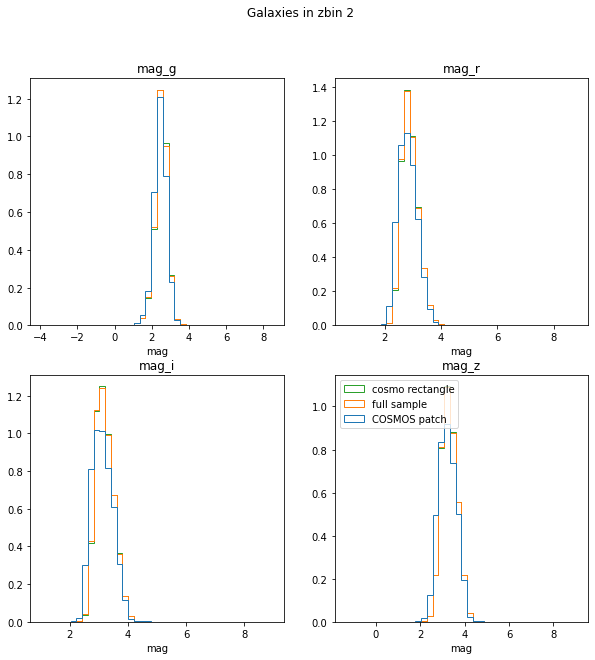

Selecting galaxies in zbin 3


In [65]:
for zbin in range(4):
    print(f'Selecting galaxies in zbin {zbin}', flush=True)
    # Based on https://github.com/xC-ell/xCell/blob/b00b448d18880afc3b405f939a7aabd934df45be/xcell/mappers/mapper_DESY1wl.py#L92-L96
    sel = photo_sample_zbin['zbin_mcal'] == zbin
    sel_xmat = photo_sample_zbin[pix_xmat]['zbin_mcal'] == zbin
    
    sel_full = photo_sample_full['zbin_mcal'] == zbin
    sel_full_rec = photo_sample_full_rec['zbin_mcal'] == zbin

    f, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax = ax.reshape(-1)
    for i, c in enumerate(photo_columns_mag):
        ax[i].hist([photo_sample[sel][c], photo_sample_full[sel_full][c], photo_sample_full_rec[sel_full_rec][c]],
                   histtype='step',
                   label=['COSMOS patch', 'full sample', 'cosmo rectangle'],
                   bins=40, density=True)
        ax[i].set_title(c)
        ax[i].set_xlabel('mag')
    ax[i].legend(loc='upper left')
    f.suptitle(f'Galaxies in zbin {zbin}')
    plt.show()
    plt.close()

# 2MPZ

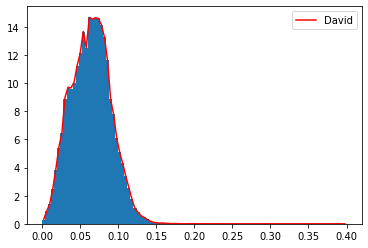

In [9]:
Nz = np.load('output/2MPZ/2MPZ_new2_Nz.npz')
Nzfile_David = np.load('output/2MPZ/nz_2MPZ.npz')
plt.bar(Nz['z'][:-1], Nz['Nz'], width=np.diff(Nz['z']), align='edge')
plt.plot(Nzfile_David['z_mid'], Nzfile_David['nz'], color='r', label='David')
plt.legend()
plt.show()
plt.close()

# HSC

In [5]:
sdir = sacc.Sacc.load_fits('../mcmc/data/cls_DESwl_covG_HSC_covGNG_DIR.fits')

HSC__0: 0.5606466833809713
HSC__1: 0.789379093215258
HSC__2: 1.1257938187080632
HSC__3: 1.347132243602121


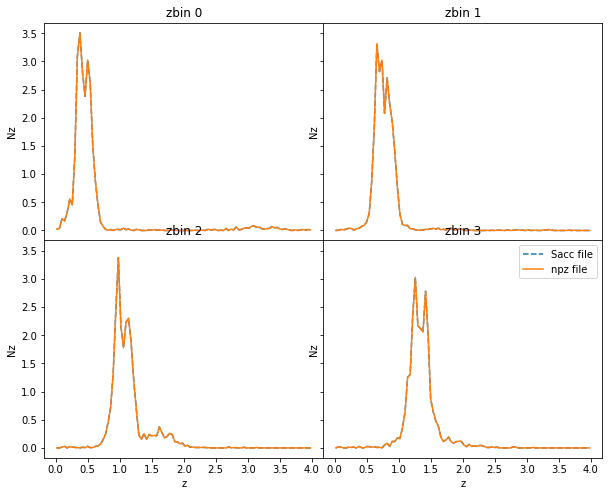

In [8]:
# Check N(z) saved correctly in sacc file
f, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
for i in range(4):
    trn = f'HSC__{i}'
    tr = sdir.tracers[trn]
    c = np.sum(tr.nz) * (tr.z[1] - tr.z[0])
    ax[i].plot(tr.z, tr.nz / c, '--', label='Sacc file')
    
    nzf = np.load(f'output/HSC/HSC_bin{i}.npz')
    ax[i].plot((nzf['z'][1:] + nzf['z'][:-1]) / 2., nzf['Nz'], label=f'npz file')    

    zmean = np.sum(tr.nz * tr.z)/np.sum(tr.nz)
    print(f'{trn}: {zmean}')
    
    ax[i].set_xlabel('z')
    ax[i].set_ylabel('Nz')
    ax[i].set_title(f'zbin {i}')
plt.legend()
plt.show()
     

# KiDS

In [ ]:
f, ax = plt.subplots(3, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
for i in range(5):
    Nz = np.load(f'output/K1000_bin{i}_Nz.npz')
    Nz_official = np.loadtxt(f'/mnt/extraspace/damonge/S8z_data/KiDS_1000/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_SOMcols_Fid_blindC_TOMO{i+1}_Nz.asc',
                            unpack=True)
    norm = np.sum(Nz_official[1] * np.diff(Nz_official[0])[0])
    ax[i].bar(Nz['z'][:-1], Nz['Nz'], width=np.diff(Nz['z']), align='edge')
    ax[i].plot(Nz_official[0], Nz_official[1] / norm, color='r', label='Official')
    ax[i].set_xlabel('z')
    ax[i].set_ylabel('Nz')
    ax[i].set_title(f'zbin {i}')
    ax[i].set_xlim([None, 2])
f.suptitle('KiDS')
plt.legend()
plt.show()

In [ ]:
np.sum(Nz['Nz'] * np.diff(Nz['z'])[0])
np.sum(Nz_official[1] * np.diff(Nz_official[0])[0])

In [ ]:
cov = np.load('../prelim_scripts/output/covar_master_K1000.npz')['covar_master']


In [ ]:
cov.shape

In [ ]:
s = sacc.Sacc.load_fits('output/cls_K1000_covG_DIR.fits')
cov = np.load('../prelim_scripts/output/covar_master_K1000.npz')['covar_master']

f, ax = plt.subplots(3, 2, figsize=(10, 8), gridspec_kw={'hspace': 0, 'wspace':0}, sharey=True)
ax = ax.reshape(-1)
for i in range(5):
    Nz_official = np.loadtxt(f'/mnt/extraspace/damonge/S8z_data/KiDS_1000/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_SOMcols_Fid_blindC_TOMO{i+1}_Nz.asc',
                            unpack=True)
    
    norm = np.sum(Nz_official[1] * np.diff(Nz_official[0])[0])
    
    tr = s.tracers[f'KiDS1000__{i}']
    norm2 = np.sum(tr.nz * np.diff(tr.z)[0])

    ax[i].errorbar(tr.z, tr.nz, yerr=tr.nz*np.sqrt(np.diag(cov)))
    ax[i].plot(Nz_official[0], Nz_official[1] / norm * norm2, color='r', label='Official')
    ax[i].set_xlabel('z')
    ax[i].set_ylabel('Nz')
    ax[i].set_title(f'zbin {i}')
    ax[i].set_xlim([None, 2])
f.suptitle('KiDS')
plt.legend()
plt.show()